# Vocoder (with Wavelets)

Ilya Pavlyukov
Dec 2022

**Usage:**
Takes `a.wav`, simulates transmission through the vocoder, reconstructs a signal and save result into `b.wav`

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

In [2]:
samplerate, wavdata = wavfile.read("1/a.wav")

/var/folders/0k/kghlvxfn3w52n271ggc0ndzh0000gn/T/ipykernel_72175/3927078962.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, wavdata = wavfile.read("1/a.wav")


In [3]:
samplerate

8000

In [4]:
rawdata = wavdata.reshape(-1)
rawdata = np.asarray(rawdata, float)
rawdata /= 255.0
rawdata -= 0.5

In [5]:
rawdata

array([ 0.01372549,  0.02941176,  0.0254902 , ..., -0.06470588,
       -0.08039216, -0.08039216])

In [6]:
def time(samples_count, x1=0.0, x2=1.0):
    return np.linspace(x1, x2, samples_count)

Text(0, 0.5, 'Amplitude')

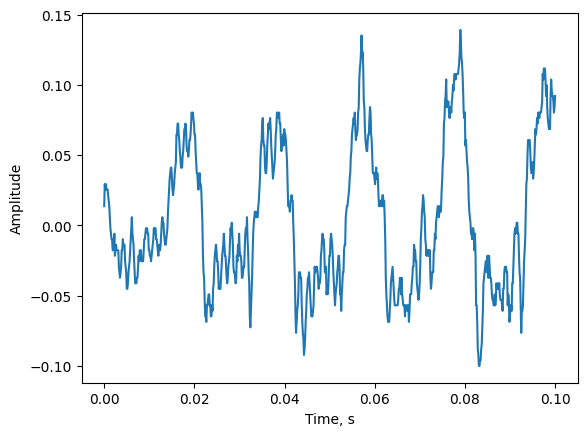

In [7]:
preview_sec = 100e-3
preview_samples = math.ceil(samplerate * preview_sec)
preview_data = rawdata[:preview_samples]
preview_dur = time(preview_samples, 0.0, preview_sec)
plt.plot(preview_dur, preview_data, label="Signal preview")
plt.xlabel("Time, s")
plt.ylabel("Amplitude")

## Window

In [8]:
batch_length_s = 50e-3  # 50ms
# (0.0;+Inf) – how far start one batch from another
# 2.0 - means there's a gap size of one batch between batches
# 1.0 - means it goes one after one without gap
# 0.5 – means batches overlaps one by another with 50% of length
batch_shift = 0.5

batch_samples = round(batch_length_s * samplerate)
print("{} samples per batch".format(batch_samples))

400 samples per batch


In [9]:
# pad with zeros at the end
data = np.copy(rawdata)
if rawdata.shape[0] % batch_samples != 0:
    data = np.concatenate((rawdata, np.zeros(batch_samples - rawdata.shape[0] % batch_samples)))

In [10]:
data.shape

(58400,)

In [11]:
batches_count = int(data.shape[0] / (batch_samples * batch_shift))
print("total: {} batches".format(batches_count))

total: 292 batches


Text(0, 0.5, 'Amplitude')

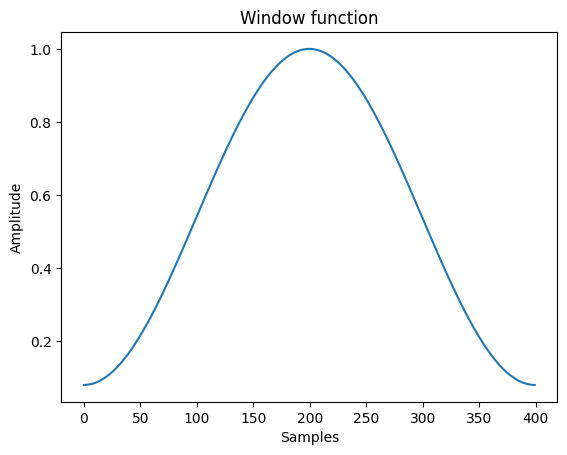

In [12]:
window = np.hamming(batch_samples)
plt.plot(window)
plt.title("Window function")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

### Windows overlapping

Text(0, 0.5, 'Amplitude')

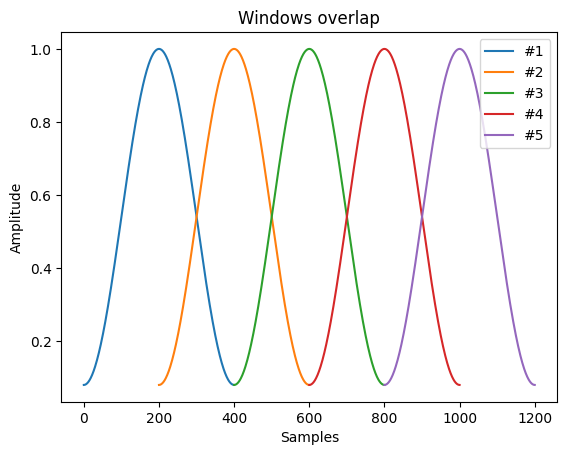

In [13]:
for i in range(5):
    x1 = batch_shift * i * batch_samples
    x2 = x1 + batch_samples
    plt.plot(np.linspace(x1, x2, batch_samples), window, label="#{}".format(i + 1))
plt.title("Windows overlap")
plt.legend()
plt.xlabel("Samples")
plt.ylabel("Amplitude")

In [14]:
output = [
    # ((x1, x2), np.array[])
]

for i in range(batches_count):
    x1 = round(batch_shift * i * batch_samples)
    x2 = round(x1 + batch_samples)

    batch_data = data[x1:x2]
    if batch_data.size < window.size:
        batch_data = np.concatenate((batch_data, np.zeros(window.size - batch_data.size)))
    clipped = np.multiply(window, batch_data)
    output.append(((x1, x2), clipped))

len(output)

292

Text(0, 0.5, 'Amplitude')

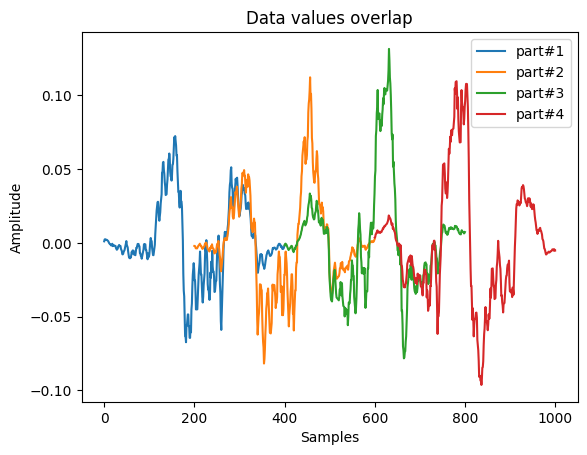

In [15]:
for i in range(0, 4):
    ((x1, x2), part) = output[i]
    plt.plot(np.linspace(x1, x2, batch_samples), part, label="part#{}".format(i + 1))
plt.title("Data values overlap")
plt.legend()
plt.xlabel("Samples")
plt.ylabel("Amplitude")

In [16]:
output_sum = np.zeros(data.shape[0])
for i in range(len(output)):
    ((x1, x2), part) = output[i]
    for j in range(len(part)):
        if x1+j >= data.size:
            break
        output_sum[x1+j] += part[j]

Text(0, 0.5, 'Amplitude')

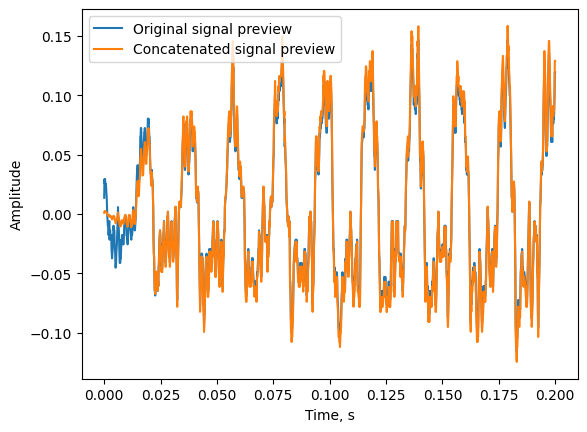

In [17]:
preview_sec = 200e-3
preview_samples = math.ceil(samplerate * preview_sec)
preview_data = output_sum[:preview_samples]
preview_dur = time(preview_samples, 0.0, preview_sec)
plt.plot(preview_dur, rawdata[:preview_samples], label="Original signal preview")
plt.plot(preview_dur, preview_data, label="Concatenated signal preview")
plt.legend()
plt.xlabel("Time, s")
plt.ylabel("Amplitude")

## FFT

$$ y = 1*sin(50*2*\pi*x) + \frac{3}{4}*sin(175*2*\pi*x) $$

Text(0.5, 1.0, 'Example normalized signal')

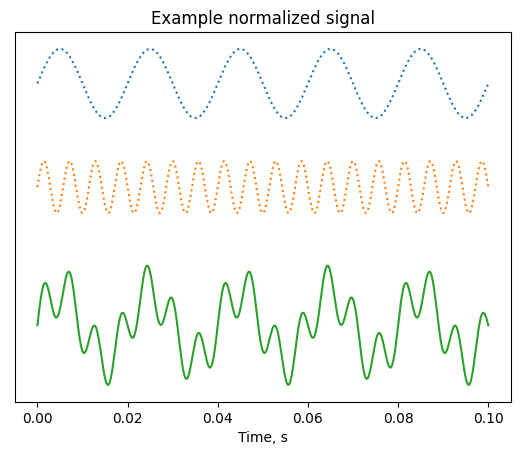

In [18]:
A1 = 1
f1 = 50
A2 = 0.75
f2 = 175
x = np.linspace(0.0, 0.1, int(samplerate * 0.1))
y1 = A1 * np.sin(2 * np.pi * f1 * x)
y2 = A2 * np.sin(2 * np.pi * f2 * x)
y = y1 + y2
plt.plot(x, y1 + 7, linestyle="dotted")
plt.plot(x, y2 + 4, linestyle="dotted")
plt.plot(x, y)
plt.yticks([])
plt.xlabel("Time, s")
plt.title("Example normalized signal")

In [19]:
def get_batch_fft(batch):
    signal_freq = np.fft.rfft(batch)
    signal_freq = np.abs(signal_freq)

    return signal_freq


def recover_signal(signal_recovered_freq):
    signal_recovered = np.fft.irfft(signal_recovered_freq)
    peak = np.max(signal_recovered[int(len(signal_recovered)*0.1):int(len(signal_recovered)*0.9)])*1.2
    signal_recovered = np.clip(signal_recovered, -peak, peak)
    return signal_recovered

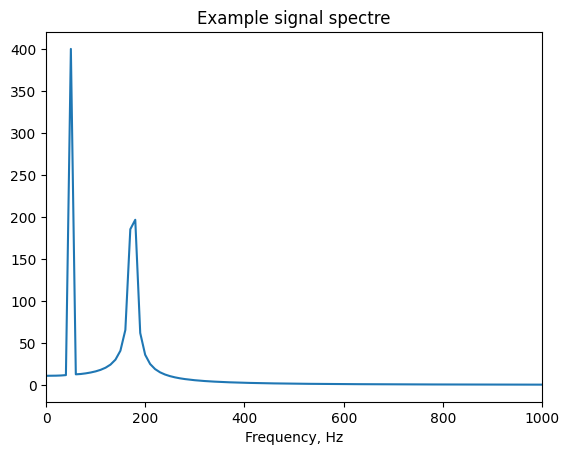

In [20]:
batch_fft = get_batch_fft(y)
dt = x[1] - x[0]
freq = np.fft.rfftfreq(len(y), dt)
plt.plot(freq, batch_fft)
plt.xlim([0, 1000])
# plt.xticks([0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250])
plt.xlabel("Frequency, Hz")
plt.title("Example signal spectre")
plt.show()

In [21]:
# ref: https://math.stackexchange.com/questions/315123/relationship-between-dft-index-values-frequency-in-a-fourier-series-and-hz
# converts Hz to DFT indices

def hz_to_index(hz, signal_length):
    return int(hz * signal_length / samplerate)

In [22]:
[i for i in range(len(batch_fft)) if batch_fft[i] > 75]

[5, 17, 18]

In [23]:
hz_to_index(50, y.size)

5

In [24]:
hz_to_index(175, y.size)

17

Text(0.5, 1.0, 'Signal -> FFT -> Signal')

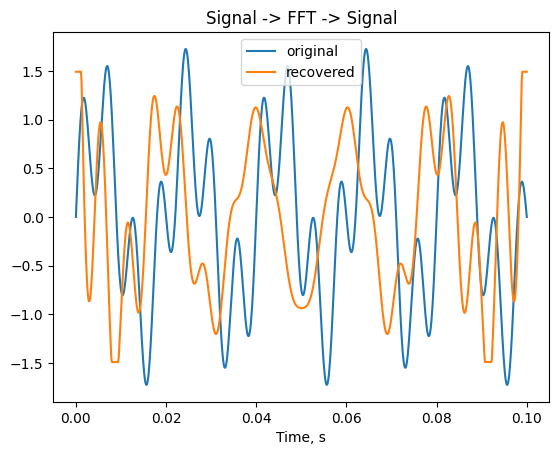

In [25]:
signal = recover_signal(batch_fft)
plt.plot(x, y, label="original")
plt.plot(x, signal, label="recovered")
plt.legend()
plt.xlabel("Time, s")
plt.title("Signal -> FFT -> Signal")

### Octaves

$$ K = 1.06 $$
$$ F_i = 30*K^{i} $$

In [26]:
band_factor = 1.06
sq2 = math.sqrt(band_factor)
mid = [round(30*band_factor**x,4) for x in range(0, 2000) if 50 < 30*band_factor**x < 4500 ]
# print(*mid, sep="\n")
bands = [(round(x/sq2, 2), round(x*sq2,2)) for x in mid if 100 < x*sq2 < 4000 ]

print("Bands count:", len(bands))
# print(*bands, sep="\n")

for i in range(len(bands)):
    print(i+1, round(bands[i][0]*sq2), bands[i][0], bands[i][1])

Bands count: 63
1 102 99.06 105.0
2 108 105.0 111.3
3 115 111.3 117.98
4 121 117.98 125.06
5 129 125.06 132.56
6 136 132.56 140.52
7 145 140.52 148.95
8 153 148.95 157.88
9 163 157.88 167.36
10 172 167.36 177.4
11 183 177.4 188.04
12 194 188.04 199.33
13 205 199.33 211.28
14 218 211.28 223.96
15 231 223.96 237.4
16 244 237.4 251.64
17 259 251.64 266.74
18 275 266.74 282.75
19 291 282.75 299.71
20 309 299.71 317.69
21 327 317.69 336.76
22 347 336.76 356.96
23 368 356.96 378.38
24 390 378.38 401.08
25 413 401.08 425.15
26 438 425.15 450.65
27 464 450.65 477.69
28 492 477.69 506.36
29 521 506.36 536.74
30 553 536.74 568.94
31 586 568.94 603.08
32 621 603.08 639.26
33 658 639.26 677.62
34 698 677.62 718.28
35 740 718.28 761.37
36 784 761.37 807.05
37 831 807.05 855.48
38 881 855.48 906.81
39 934 906.81 961.21
40 990 961.21 1018.89
41 1049 1018.89 1080.02
42 1112 1080.02 1144.82
43 1179 1144.82 1213.51
44 1249 1213.51 1286.32
45 1324 1286.32 1363.5
46 1404 1363.5 1445.31
47 1488 1445.31 153

In [27]:
def freq_octaves(signal_freq, signal_length):
    octaves = np.zeros((len(bands)), dtype=float)
    for i in range(len(bands)):
        band = bands[i]
        s = hz_to_index(band[0], signal_length)
        e = hz_to_index(band[1], signal_length)
        if s == e:
            continue

        v = np.sum(signal_freq[s:e]) # try average for example

        if v > 0.15: # filter low power frequencies
            octaves[i] = v

    return octaves

In [28]:
recover_mode = 'mid'

def recover_freq(freq_len, sig_octaves, signal_length):
    signal_recovered_freq = np.zeros(freq_len)
    for i in range(len(bands)):
        band = bands[i]
        if recover_mode == 'whole_band':
            s = hz_to_index(band[0], signal_length)
            e = hz_to_index(band[1], signal_length)
            signal_recovered_freq[s:e] = sig_octaves[i]
        if recover_mode == 'mid':
            mid = math.sqrt(band[0]*band[1])
            signal_recovered_freq[hz_to_index(mid, signal_length)] = sig_octaves[i]
    return signal_recovered_freq

Text(0.5, 1.0, 'Signal -> FFT -> Octaves -> Signal')

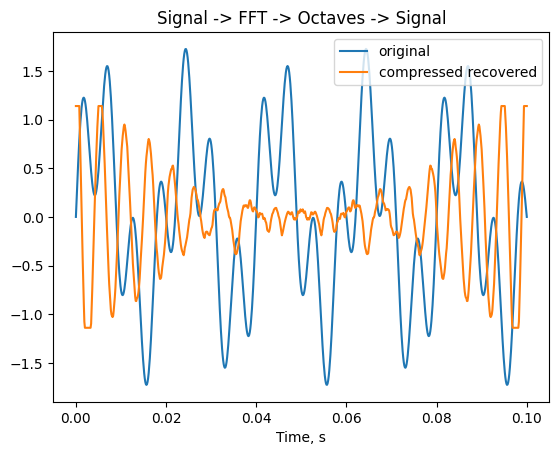

In [29]:
octaves = freq_octaves(batch_fft, y.size)
recovered_freq = recover_freq(batch_fft.size, octaves, y.size)
signal = recover_signal(recovered_freq)
plt.plot(x, y, label="original")
plt.plot(x, signal, label="compressed recovered")
plt.legend()
plt.xlabel("Time, s")
plt.title("Signal -> FFT -> Octaves -> Signal")

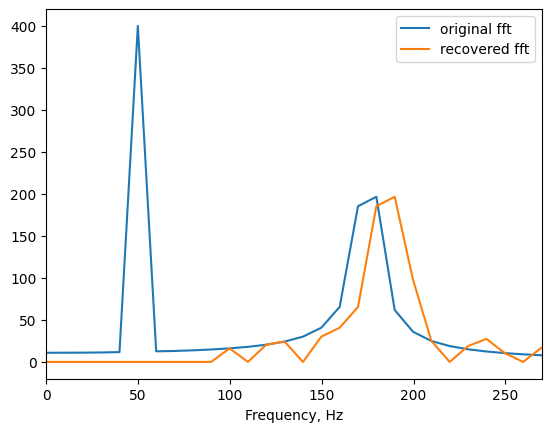

In [30]:
dt = x[1] - x[0]
freq = np.fft.rfftfreq(len(y), dt)
plt.plot(freq, batch_fft, label="original fft")
plt.plot(freq, recovered_freq, label="recovered fft")
plt.xlim([0, 270])
plt.legend()
plt.xlabel("Frequency, Hz")
plt.show()
# the graph is so-so, because the frequency bands are matched to the formant regions not to an example signal

## All together

In [31]:
output = [
    # ((x1, x2), np.array[])
]

for i in range(batches_count):
    x1 = round(batch_shift * i * batch_samples)
    x2 = round(x1 + batch_samples)

    batch_data = data[x1:x2]
    if batch_data.size < window.size:
        batch_data = np.concatenate((batch_data, np.zeros(window.size - batch_data.size)))
    clipped = np.multiply(window, batch_data)
    batch_fft = get_batch_fft(clipped)
    octaves = freq_octaves(batch_fft, clipped.size)
    recovered_freq = recover_freq(batch_fft.size, octaves, clipped.size)
    signal = recover_signal(recovered_freq)
    signal = np.multiply(window, signal)
    output.append(((x1, x2), signal))

len(output)

292

Text(0, 0.5, 'Amplitude')

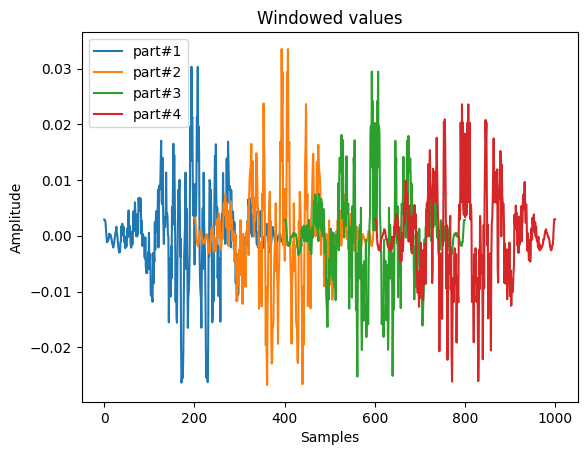

In [32]:
for i in range(4):
    ((x1, x2), part) = output[i]
    plt.plot(np.linspace(x1, x2, batch_samples), part, label="part#{}".format(i + 1))
plt.title("Windowed values")
plt.legend()
plt.xlabel("Samples")
plt.ylabel("Amplitude")

In [33]:
output_sum = np.zeros(data.shape[0])
for i in range(len(output)):
    ((x1, x2), part) = output[i]
    for j in range(len(part)):
        if x1+j >= data.size:
            break
        output_sum[x1+j] += part[j]

Text(0.5, 1.0, 'Reconstructed signal difference')

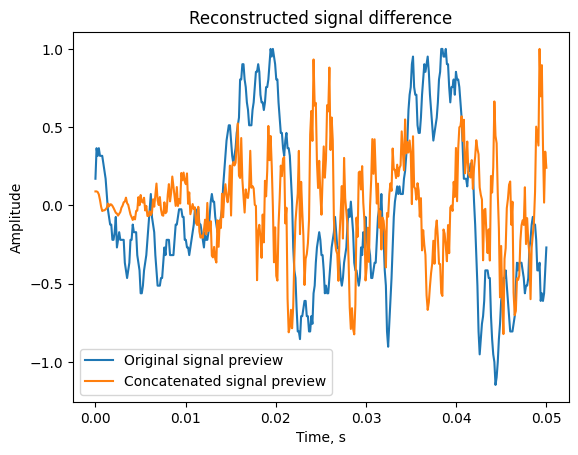

In [34]:
preview_sec = 50e-3
preview_samples = math.ceil(samplerate * preview_sec)
preview_data = output_sum[:preview_samples]
preview_dur = time(preview_samples, 0.0, preview_sec)
plt.plot(preview_dur, rawdata[:preview_samples] / np.max(rawdata[:preview_samples]), label="Original signal preview")
plt.plot(preview_dur, preview_data / np.max(preview_data), label="Concatenated signal preview")
plt.legend()
plt.xlabel("Time, s")
plt.ylabel("Amplitude")
plt.title("Reconstructed signal difference")

### Save to wav

In [35]:
output_sum += 0.5
output_sum *= 255.0
output_sum = np.asarray(output_sum, int).astype('uint8')
wavfile.write("b.wav", samplerate, output_sum)

# Proof of compression

## Wave samples in uncompressed wav file:

Example:
T = 10 sec – duration
Fs = 8000 Hz – sampling frequency
N = 1 – bytes per sample

$$ M = TNF_s = 80000\;\rm{bytes} $$

In [36]:
T = rawdata.size/samplerate
M_w = T*samplerate*1
print("{} bytes".format(M_w))

58177.0 bytes


---

## Vocoder (Bands average):

Example:
T = 10 sec – duration
D = 50 ms – window width
S = 0.5 – window shift (efficiency coefficient [0.0;1.0])
C = 53 – octaves count
N = 1 – bytes per octave

$$ M = NC(\frac{T}{DS}) = 21200\;\rm{bytes} $$

In [37]:
M_v = round(1*len(bands)*(T/(batch_length_s*batch_shift)))
print("{} bytes".format(M_v))

18326 bytes


## Data compression ratio

$$ {\rm {Compression\;Ratio}}={\frac {\rm {Uncompressed\;Size}}{\rm {Compressed\;Size}}} $$

In [38]:
r = round(M_w/M_v, 2)
print("{}".format(r))

3.17


$$ {\displaystyle {\rm {Space\;Saving}}=1-{\frac {\rm {Compressed\;Size}}{\rm {Uncompressed\;Size}}}} $$

In [39]:
ss = round((1 - M_v/M_w)*100, 2)
print("{}%".format(ss))

68.5%
